In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch 
import json
import sys
import torch
import torch.nn.functional as F
import os
import numpy as np

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/george-vengrovski/anaconda3/envs/t

In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21)
test_dataset = SongDataSet_Image(test_dir, num_classes=21)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

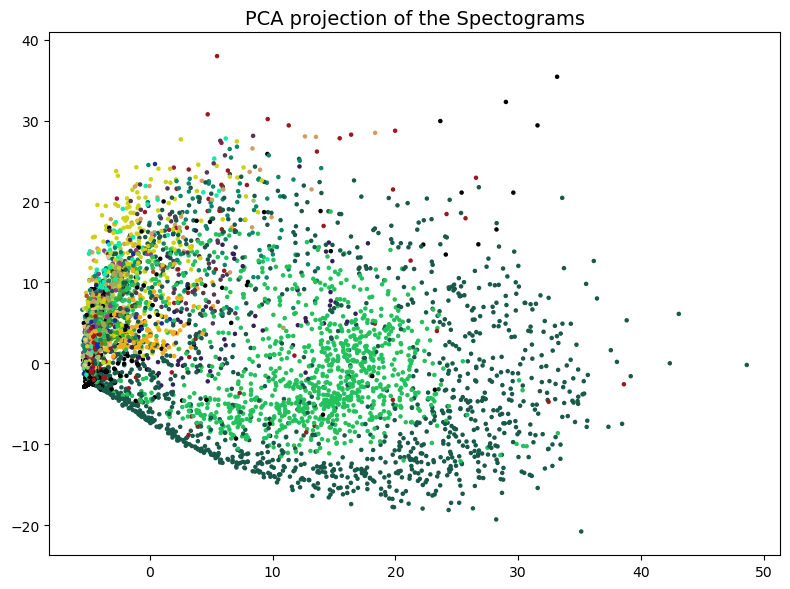

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

reductions_dims = 2
plot_figure = True

list_of_data = []
list_of_ground_truth = []

for i, (data, ground_truth_label) in enumerate(test_loader):
    # Remove channel dimension (used for convolutional layers)
    data = data[:, 0, :, :]
    # Permute dimensions
    data = data.permute(0, 2, 1)
    # Convert labels to indices
    ground_truth_label = ground_truth_label.argmax(-1)
    # Convert to numpy arrays
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    # Reshape labels
    ground_truth_label = ground_truth_label.reshape(-1, 1)
    data = data.reshape(-1, 1 * 196)
    # Append to lists
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    # Break the loop after processing 101 batches
    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]

# Load color map data
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Map labels to colors
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

# Prepare colors for plotting points
colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)

# Initialize and apply PCA
pca = PCA(n_components=reductions_dims, random_state=42)
embedding_outputs = pca.fit_transform(list_of_data_sampled)

# Plot if conditions are met
if reductions_dims == 2 and plot_figure == True:
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('PCA projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()


In [10]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="pca", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=2)
classifier_model = classifier_model.to(device)

Batch 10: FER = 95.80%, Train Loss = 4.0766, Val Loss = 4.6355
Batch 20: FER = 96.29%, Train Loss = 3.6644, Val Loss = 4.3092
Batch 30: FER = 95.65%, Train Loss = 3.5666, Val Loss = 3.6702
Batch 40: FER = 94.30%, Train Loss = 2.9671, Val Loss = 3.2197
Batch 50: FER = 88.13%, Train Loss = 2.8718, Val Loss = 2.8926
Batch 60: FER = 59.81%, Train Loss = 2.5360, Val Loss = 2.7100
Batch 70: FER = 56.33%, Train Loss = 2.4717, Val Loss = 2.5341
Batch 80: FER = 54.42%, Train Loss = 2.2979, Val Loss = 2.4426
Batch 90: FER = 47.62%, Train Loss = 2.3950, Val Loss = 2.3644
Batch 100: FER = 46.20%, Train Loss = 2.2267, Val Loss = 2.2648


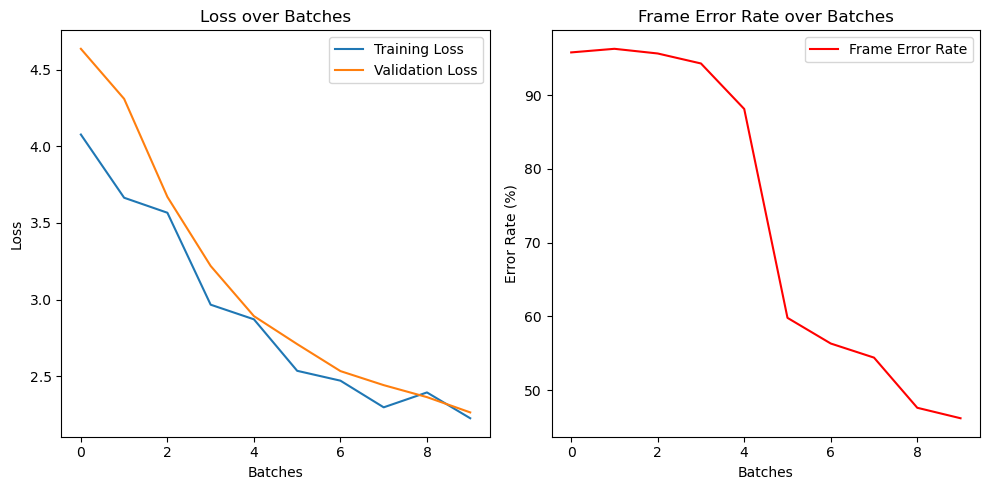

In [11]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=10, desired_total_batches=100, patience=4)
trainer.train()

In [12]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

Evaluating: 100%|██████████| 142/142 [00:04<00:00, 34.85batch/s]
